In [1]:
!pip install -q tensorflow-io
import os
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Lambda, Input, Dense, \
                         Convolution2D, MaxPooling2D,Activation, \
                         Dropout, Flatten,  GlobalAveragePooling2D
from keras.layers.merge import Concatenate
from tensorflow.keras.models import Model, Sequential 
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from pathlib import Path
import tensorflow_hub as hub

from utils import DatasetBuilder ,EvaluateModel ,ModelUtils

     |████████████████████████████████| 25.9 MB 1.2 MB/s 


In [2]:
DATASET_PATH = os.path.join(os.getcwd(),'drive',"MyDrive", 'Car-Color-Recognition','CarDS')
BATCH_SIZE = 32
IMAGE_SIZE = (300 ,300)
colorspace = "XYZ"
model_name = "XYZ"
dsBuilder = DatasetBuilder(DATASET_PATH ,image_size = IMAGE_SIZE ,batch_size = BATCH_SIZE)
train_ds , val_ds = dsBuilder.create('train') , dsBuilder.create('val')
class_names=train_ds.class_names
NUM_CLASSES = len(class_names)

class_weights = dsBuilder.get_class_weights(train_ds)

for key ,value in class_weights.items() : print("{} : {}".format(class_names[key], value.round(3)))

Found 19171 files belonging to 16 classes.
Found 3491 files belonging to 16 classes.
beige : 1.161
black : 0.97
blue : 1.087
brown : 1.14
cream : 2.014
crimson : 1.945
gold : 2.147
green : 1.325
grey : 0.873
navy-blue : 2.031
orange : 1.39
red : 1.152
silver : 1.268
titanium : 1.997
white : 0.209
yellow : 1.297


In [3]:
train_ds = (
    train_ds.
    map(lambda img, lbl: (img/255., lbl), num_parallel_calls=tf.data.AUTOTUNE).
    map(lambda img ,lbl : (DatasetBuilder.rgb2xyz(img) ,lbl) ,num_parallel_calls=tf.data.AUTOTUNE).
    prefetch(tf.data.AUTOTUNE))

val_ds = (
    val_ds.
    map(lambda img, lbl: (img/255., lbl), num_parallel_calls=tf.data.AUTOTUNE).
    map(lambda img ,lbl : (DatasetBuilder.rgb2xyz(img) ,lbl) ,num_parallel_calls=tf.data.AUTOTUNE).
    prefetch(tf.data.AUTOTUNE))

In [ ]:
augmentation = Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.05),
    ]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

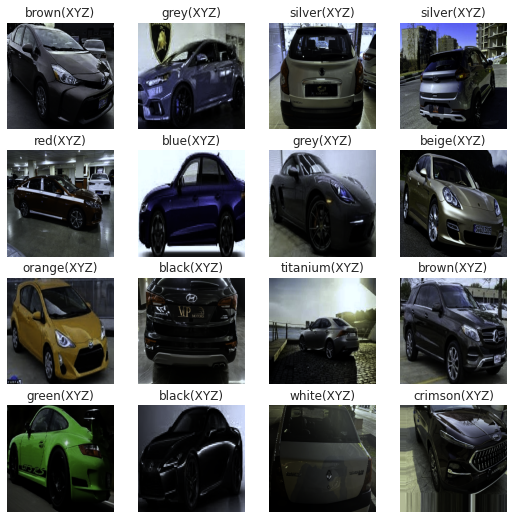

In [ ]:
fig=plt.figure(figsize=(9, 9))
for images, labels in train_ds.take(1):
    for i in range(16):
      plt.subplot(4, 4, i + 1)
      image = tf.expand_dims(images[i] ,axis=0)
      #image = tf.cast(image * 255.0, tf.uint8)
      lbl = "{}({})".format(class_names[labels[i].numpy().argmax()] , colorspace )
      plt.imshow(tf.squeeze(image))
      plt.title(lbl)
      plt.axis("off")
    break

In [ ]:
do_fine_tuning = True

url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2"
base_model = hub.KerasLayer(url,trainable=do_fine_tuning)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    augmentation,
    base_model,
    Dense(400),
    Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES,activation = "softmax", kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1536)              12930622  
                                                                 
 dense (Dense)               (None, 400)               614800    
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                6416      
                                                                 
Total params: 13,551,838
Trainable params: 13,442,622
Non-trainable params: 109,216
_________________________________________________________________


In [ ]:
model_utils = ModelUtils(model_name ,"HUB")
run_index = 1
callbacks= model_utils.get_callbacks(run_index = run_index )
model = model_utils.make_or_restore_model(model,"SGD",lr = 1e-2)
n_epochs = 50
print("{}: ".format(model_name))
model.fit(train_ds,
          validation_data=val_ds,
          epochs=n_epochs,
          callbacks=callbacks,
          class_weight = class_weights,
          initial_epoch = 5
          )   

Restoring from /content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/XYZ/_5.h5
XYZ: 
Epoch 6/50
600/600 [==============================] - ETA: 0s - loss: 0.2554 - accuracy: 0.9120
Epoch 6: val_loss improved from inf to 0.63867, saving model to /content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/XYZ/_6.h5
600/600 [==============================] - 4374s 7s/step - loss: 0.2554 - accuracy: 0.9120 - val_loss: 0.6387 - val_accuracy: 0.8313 - lr: 0.0100
Epoch 7/50
600/600 [==============================] - ETA: 0s - loss: 0.2299 - accuracy: 0.9221
Epoch 7: val_loss improved from 0.63867 to 0.61574, saving model to /content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/XYZ/_7.h5
600/600 [==============================] - 394s 653ms/step - loss: 0.2299 - accuracy: 0.9221 - val_loss: 0.6157 - val_accuracy: 0.8382 - lr: 0.0100
Epoch 8/50
600/600 [==============================] - ETA: 0s - loss: 0.2014 - accuracy: 0.9328
Epoch 8: val_loss did not improve 

In [ ]:
model_utils.save_model_and_history(model ,run_index)

INFO:tensorflow:Assets written to: ram://c79d0374-9d49-463a-ba29-f8ee6439ca8b/assets


INFO:tensorflow:Assets written to: ram://c79d0374-9d49-463a-ba29-f8ee6439ca8b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Car-Color-Recognition/Models/XYZ/1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Car-Color-Recognition/Models/XYZ/1/assets


In [4]:
run_index = 1
model_utils = ModelUtils(model_name ,"HUB")
model = keras.models.load_model('/content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/XYZ/_7.h5' ,custom_objects={'KerasLayer':hub.KerasLayer})

In [5]:
eval = EvaluateModel(model ,val_ds ,class_names,"XYZ")

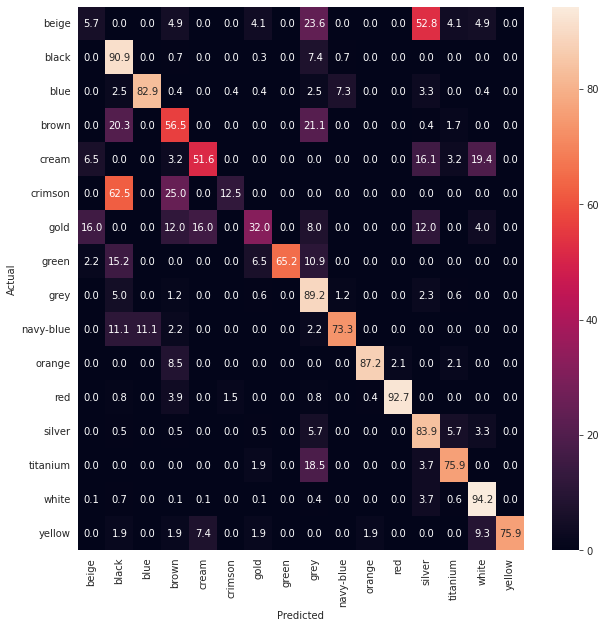

In [6]:
eval.plot_confusion()

In [7]:
eval.report()

Report CSV file added to logs .


,precision,recall,f1-score,support
beige,0.437500,0.056911,0.100719,123.000000
black,0.724599,0.909396,0.806548,298.000000
blue,0.978541,0.829091,0.897638,275.000000
brown,0.783626,0.565401,0.656863,237.000000
cream,0.640000,0.516129,0.571429,31.000000
crimson,0.166667,0.125000,0.142857,8.000000
gold,0.333333,0.320000,0.326531,25.000000
green,1.000000,0.652174,0.789474,46.000000
grey,0.676991,0.892128,0.769811,343.000000
navy-blue,0.559322,0.733333,0.634615,45.000000
